# Hot off the press from chatgpt o3-mini-high

In [4]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:
key = random.PRNGKey(0) 

In [34]:
class GenerativeRBM:
    def __init__(self, n_hidden, data_path=None, key=None):
        """
        Initializes the RBM with the given number of hidden units.
        Data is expected to be arranged such that each column is a sample
        and each row is a variable.
        If no random key is provided, a default one is created.
        """
        if key is None:
            key = random.PRNGKey(0)
        self.key = key
        self.data = self.load_data(data_path)
        self.set_empirical_means()
        self.n_visible = self.data.shape[0]  # each row is a variable
        self.n_hidden = n_hidden
        self.key, subkey = random.split(self.key)
        # Initialize weights and biases.
        # W has shape (n_hidden, n_visible)
        self.W = random.normal(subkey, shape=(n_hidden, self.n_visible)) * 0.1
        self.h_bias = jnp.zeros((n_hidden,))
        self.v_bias = jnp.zeros((self.n_visible,))

    def load_data(self, data_path):
        if data_path is None:
            mnist = fetch_openml('mnist_784', version=1)
            # Original shape is (n_samples, n_features). Transpose to have shape (n_features, n_samples).
            X = np.array(mnist.data.T, dtype=np.float32) / 255.0  # Normalize to [0,1]
            print("Data shape:", X.shape)
            X = (X > 0.5).astype(np.float32)  # Binarize the data
        else:
            # Assume CSV has samples as rows; transpose to get columns as samples.
            X = pd.read_csv(data_path, index_col=0).values.T
        # Split into training and test sets.
        # train_test_split expects samples as rows, so we transpose before and after splitting.
        X_train, X_test = train_test_split(X.T, test_size=0.2, random_state=int(self.key[0]))
        # Transpose back so that each column is a sample.
        X_train = jnp.array(X_train.T)
        X_test = jnp.array(X_test.T)
        self.X_train = X_train
        self.X_test = X_test
        return X

    def sigmoid(self, x):
        return 1.0 / (1.0 + jnp.exp(-x))

    def sample_h(self, v):
        """
        Given a batch of visible units (v) with shape (n_visible, batch_size),
        sample the hidden units.
        Returns both the binary samples and their probabilities.
        """
        # Compute hidden activations: shape (n_hidden, batch_size)
        p_h = self.sigmoid(jnp.dot(self.W, v) + self.h_bias[:, None])
        self.key, subkey = random.split(self.key)
        h = random.bernoulli(subkey, p_h).astype(jnp.float32)
        return h, p_h

    def sample_v(self, h):
        """
        Given a batch of hidden units (h) with shape (n_hidden, batch_size),
        sample the visible units.
        Returns both the binary samples and their probabilities.
        """
        # Compute visible activations: shape (n_visible, batch_size)
        p_v = self.sigmoid(jnp.dot(self.W.T, h) + self.v_bias[:, None])
        self.key, subkey = random.split(self.key)
        v = random.bernoulli(subkey, p_v).astype(jnp.float32)
        return v, p_v

    def contrastive_divergence(self, v0, k=1):
        """
        Performs k steps of Gibbs sampling starting at the visible units v0.
        v0 is expected to have shape (n_visible, batch_size).
        """
        vk = v0
        for _ in range(k):
            h, _ = self.sample_h(vk)
            vk, _ = self.sample_v(h)
        return vk

    def train_batch(self, v0, learning_rate=0.01, k=1, l2_reg=0.0):
        """
        Updates the parameters of the RBM using Contrastive Divergence.
        
        Parameters:
          v0 (array): Batch of visible units with shape (n_visible, batch_size).
          learning_rate (float): Learning rate for the update.
          k (int): Number of Gibbs sampling steps.
          l2_reg (float): L2 regularization coefficient.
        """
        vk = self.contrastive_divergence(v0, k)
        h0, _ = self.sample_h(v0)
        hk, _ = self.sample_h(vk)
        batch_size = v0.shape[1]
        # Compute gradients (note: outer products are computed by dotting with the transpose).
        delta_W = jnp.dot(h0, v0.T) - jnp.dot(hk, vk.T)
        delta_v_bias = jnp.sum(v0 - vk, axis=1)  # Sum over samples (columns)
        delta_h_bias = jnp.sum(h0 - hk, axis=1)  # Sum over samples (columns)
        # Update parameters with optional L2 regularization.
        self.W = self.W + learning_rate * (delta_W / batch_size - l2_reg * self.W)
        self.v_bias = self.v_bias + learning_rate * delta_v_bias / batch_size
        self.h_bias = self.h_bias + learning_rate * delta_h_bias / batch_size

    def reconstruct(self, v, k=1):
        """
        Reconstructs the input visible units by running Gibbs sampling.
        v is expected to have shape (n_visible, batch_size).
        """
        return self.contrastive_divergence(v, k)

    def generate(self, n_samples, gibbs_steps=100):
        """
        Generates new samples from the model by starting with random noise and
        running Gibbs sampling for a specified number of steps.
        
        Returns:
          samples with shape (n_visible, n_samples), where each column is a sample.
        """
        self.key, subkey = random.split(self.key)
        # Initialize samples with shape (n_visible, n_samples)
        samples = random.bernoulli(subkey, p=jnp.ones((self.n_visible, n_samples)) * 0.5).astype(jnp.float32)
        for _ in range(gibbs_steps):
            h, _ = self.sample_h(samples)
            samples, _ = self.sample_v(h)
        return samples

    @staticmethod
    def compute_averages(samples):
        """
        Computes the mean (per variable) and covariance from the samples.
        Samples are expected to have shape (n_visible, n_samples).
        """
        return jnp.mean(samples, axis=1), jnp.cov(samples)

    def set_empirical_means(self):
        self.mean, self.cov = self.compute_averages(self.data)

    def compute_squared_deviations(self, samples):
        sample_mean, cov = self.compute_averages(samples)
        return (sample_mean - self.mean)**2, (cov - self.cov)**2

    def split_data_in_half(self):
        cols = self.data.shape[1]
        perm = jax.random.permutation(self.key, cols)
        fh_indices = perm[:cols // 2]
        sh_indices = perm[-cols // 2:]
        first_half_data = self.data[:, fh_indices]
        second_half_data = self.data[:, sh_indices]
        return first_half_data, second_half_data

    def background_model_squared_deviations(self):
        first_half_data, second_half_data = self.split_data_in_half()
        fhm, fhc = self.compute_averages(first_half_data)
        shm, shc = self.compute_averages(second_half_data)
        return (fhm - shm)**2, (fhc - shc)**2

    def compute_background_rmse(self):
        mean_diffs, cov_diffs = self.background_model_squared_deviations()
        return jnp.sqrt(jnp.mean(mean_diffs)), jnp.sqrt(jnp.mean(cov_diffs.flatten()))

    def compute_rmse(self, samples):
        mean_devs, cov_devs = self.compute_squared_deviations(samples)
        return jnp.sqrt(jnp.mean(mean_devs)), jnp.sqrt(jnp.mean(cov_devs.flatten()))

    def fit(self, X_train, epochs=10, batch_size=64, learning_rate=0.01, k=1, l2_reg=0.0, sample_number=1000):
        """
        Trains the RBM on the training data.
        
        Parameters:
          X_train (array): Training data as a JAX array with shape (n_visible, n_train),
                           where each column is a sample.
          epochs (int): Number of epochs.
          batch_size (int): Number of samples per batch.
          learning_rate (float): Learning rate.
          k (int): Number of Gibbs sampling steps per batch.
          l2_reg (float): L2 regularization coefficient.
          
        Returns:
          losses: A list of reconstruction losses per epoch.
          sample_list: An array containing generated samples at intervals.
        """
        num_samples = X_train.shape[1]
        losses = []
        sample_list = []
        # Shuffle training data along the sample axis (columns).
        permutation = np.random.permutation(num_samples)
        X_train = X_train[:, permutation]
        for epoch in range(epochs):
            epoch_loss = 0.0
            for i in range(0, num_samples, batch_size):
                batch = X_train[:, i:i+batch_size]
                self.train_batch(batch, learning_rate=learning_rate, k=k, l2_reg=l2_reg)
                v_recon = self.reconstruct(batch)
                epoch_loss += jnp.sum((batch - v_recon) ** 2)
            losses.append(epoch_loss)
            if (epoch * 10) % epochs == 0:
                print(f"Epoch {epoch}/{epochs}, Reconstruction Loss: {epoch_loss:.4f}")
                samples = self.generate(sample_number, gibbs_steps=1000)
                sample_list.append(samples)
        return losses, jnp.array(sample_list)

    def plot_deviations_over_time(self, train_args):
        losses, samples = self.fit(**train_args)
        fig, axs = plt.subplots(2, 1, height_ratios=[4, 1], sharex=True)
        errors = jnp.array(jax.vmap(self.compute_rmse)(samples)) 
        background_mean, background_cov = self.compute_background_rmse()
        axs[0].plot(errors[0, :], label='means rmse (samples vs data)') 
        axs[0].hlines(background_mean, 0, errors.shape[1] - 1, ls='--', color='tab:blue', label='means rmse (data vs data)')
        axs[0].plot(errors[1, :], label='covs rmse (samples vs data)') 
        axs[0].hlines(background_cov, 0, errors.shape[1] - 1, ls='--', color='tab:orange', label='covs rmse (data vs data)')
        axs[0].set_yscale('log')
        axs[1].plot(losses)
        axs[1].set_yscale('log') 
        axs[1].set_xlabel('epoch') 
        axs[1].set_ylabel('reconstruction loss')
        axs[0].legend()
        return fig, axs, samples, errors 
    
    def plot_samples(self, samples, indices=None): 
        # samples is assumed to be timepoints x num_variables x num_samples. indices is a subset of range(len(timepoints)), so you can plot a subset if needed. 
        if indices is None: 
            indices = range(len(samples))
        if len(indices) > 10: 
            indices = range(0, len(indices), len(indices) // 10) 
        fig, axs = plt.subplots(10, 10, figsize=(20, 20)) 
        [(ax.set_xticks([]), ax.set_yticks([])) for ax in axs.flatten()]
        for i in indices: 
            key, subkey = self.key.split(key)
            sample_idx = jax.random.choice(self.subkey, np.arange(samples.shape[2]), shape=(10, ), replace=False)
            dim = int(jnp.sqrt(samples.shape[1]))
            for ax_idx, j in enumerate(sample_idx): 
                axs[i, ax_idx].imshow(samples[i, :, j].reshape(dim, dim)) 
        return fig, axs 
        
    

In [ ]:
jax.random.split

In [35]:
# ----------------------------------------------------------------
# Demonstration code:
def demo_generative_rbm(epochs=10):

    # Create the RBM instance.
    rbm = GenerativeRBM(n_hidden=128)

    # Train the RBM.
    losses, samples = rbm.fit(rbm.X_train, epochs=epochs, batch_size=64, learning_rate=0.01, k=1, l2_reg=0.001)
    # Reconstruct test samples.
    test_samples = rbm.X_test[:, :10]
    v_recon = rbm.reconstruct(test_samples)

    # Plot original and reconstructed images.
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(np.array(test_samples[:, i]).reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(np.array(v_recon[:, i]).reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")
    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

    # Generate new samples.
    generated_samples = rbm.generate(n_samples=10, gibbs_steps=100)
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        axes[i].imshow(np.array(generated_samples[:, i]).reshape(28, 28), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Newly Generated Samples")
    plt.show()
    return rbm, losses, samples 

# To run the demonstration, simply call:
# demo_generative_rbm()


P = 2
rbm, losses, samples = demo_generative_rbm(epochs=5) 

In [36]:
rbm = GenerativeRBM(n_hidden=128)

Data shape: (784, 70000)


Epoch 0/2, Reconstruction Loss: 6663612.0000
Epoch 1/2, Reconstruction Loss: 4754037.0000


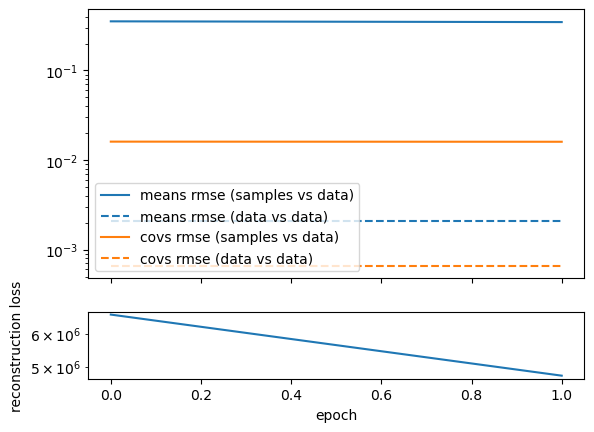

In [37]:
train_args = {'X_train': rbm.X_train, 
              'epochs': 2, 
              'batch_size': 64, 
              'learning_rate': 0.01, 
              'k': 1, 
              'l2_reg': 0.0, 
              'sample_number': 1000}

fig, axs, samples, err = rbm.plot_deviations_over_time(train_args)

[394 445   2 644 376 119  74 508 473 581]
[394 445   2 644 376 119  74 508 473 581]


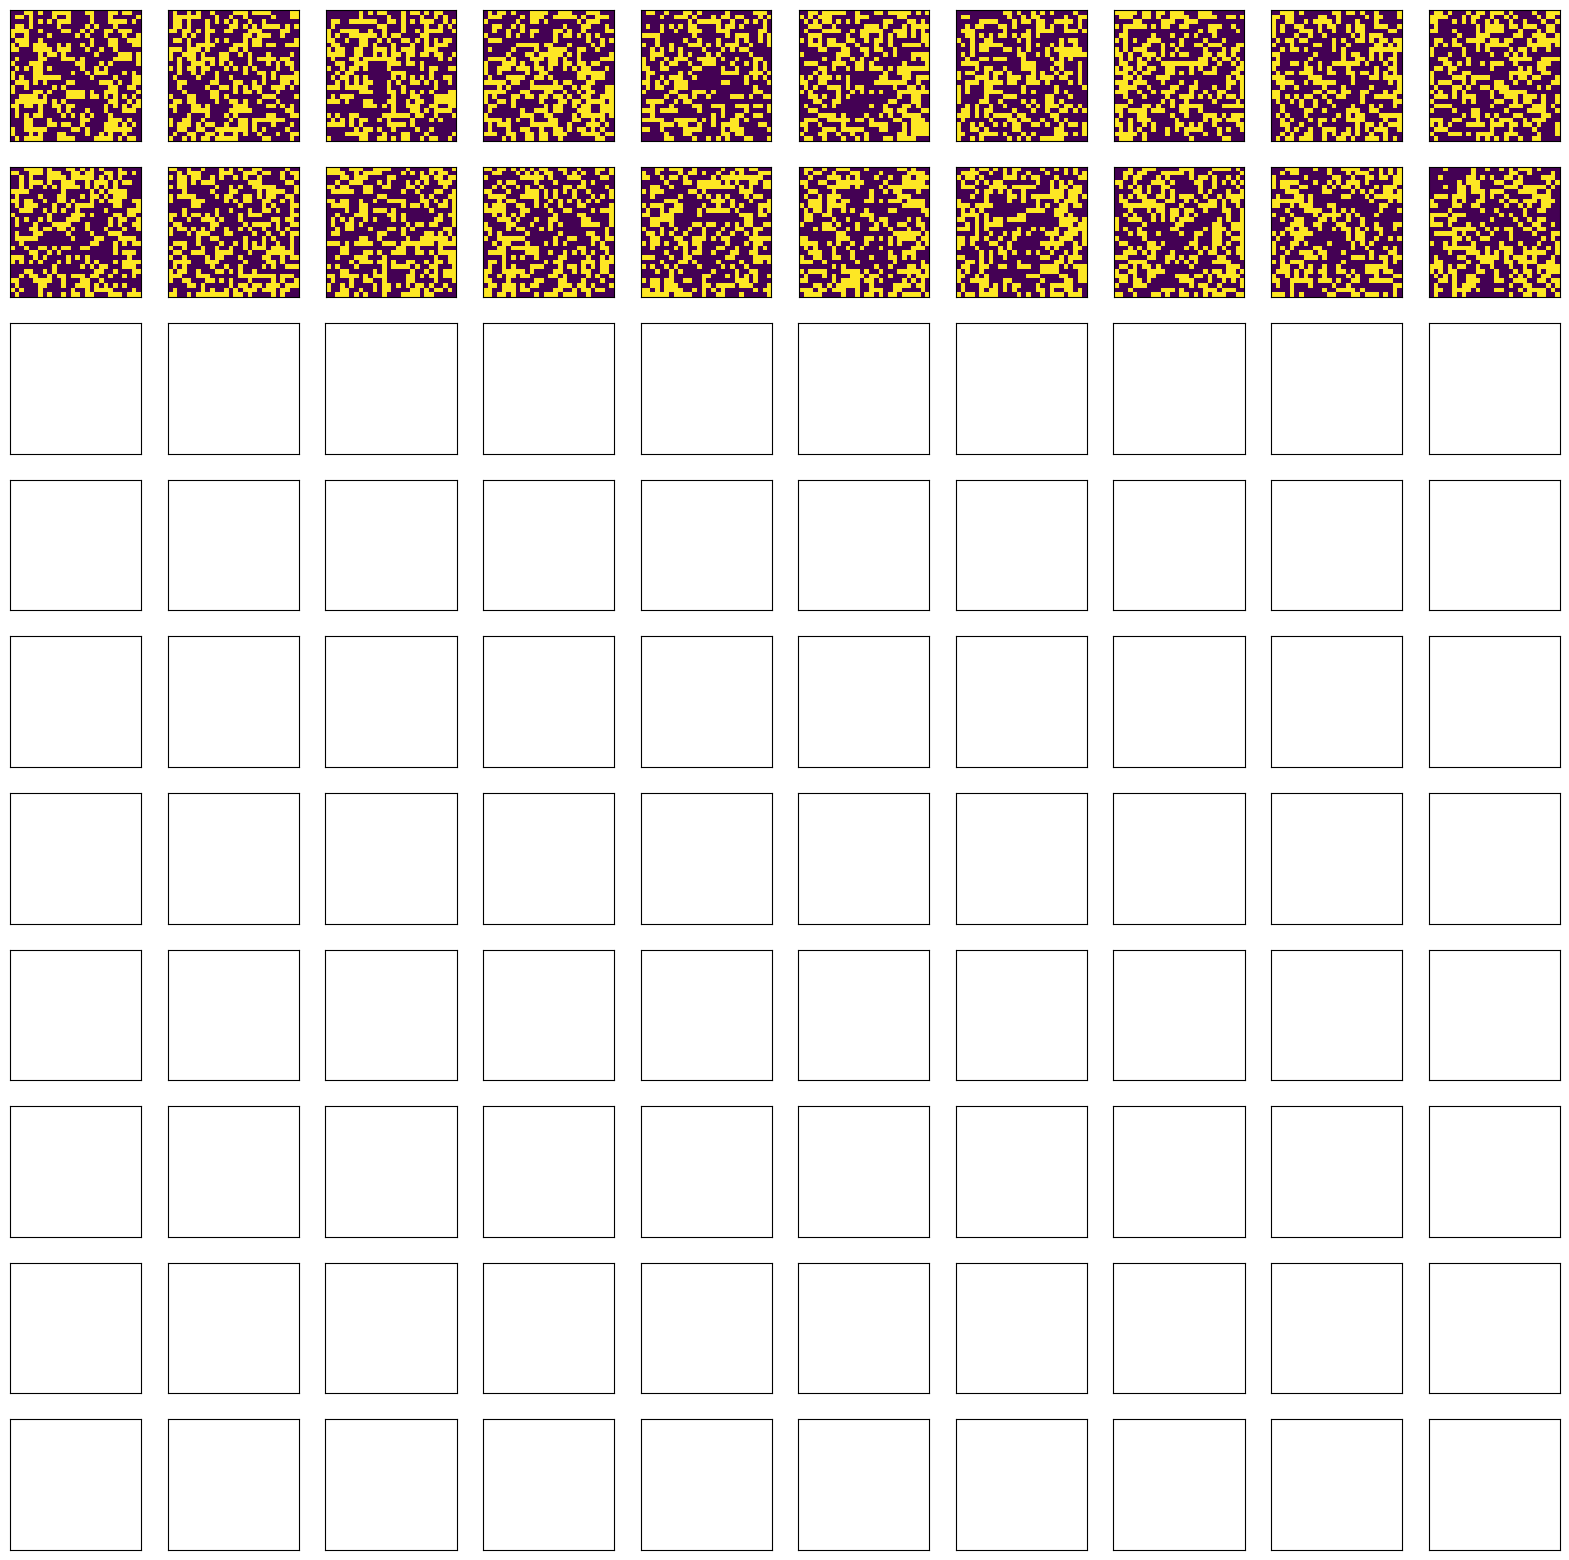

In [38]:
rbm.plot_samples(samples); 

In [14]:
samples.shape

(2, 784, 1000)

In [86]:
errors = jnp.array(jax.vmap(rbm.compute_rmse)(samples)) 

In [88]:
samples.shape

(10, 784, 1000)

In [89]:
errors

(2, 10)

Training for 10 epochs buys a 50% decrease in reconstruction error, but the newly generated samples look like white noise. 1000 epochs is much better--the new samples look great. 